In [1]:
import time
import random
import timeit
import statistics
import itertools

import matplotlib.pyplot as plt
import pandas as pd

from memory_profiler import memory_usage

In [64]:
plt.rcParams['figure.figsize'] = (20, 10)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import benchmarks

In [62]:
%memit benchmarks.benchmark1()

peak memory: 142.65 MiB, increment: 0.00 MiB


In [63]:
%memit benchmarks.benchmark1b()

peak memory: 142.65 MiB, increment: 0.00 MiB


In [49]:
# Placeholders

class placeholder:
    @staticmethod
    def product(*iterables, repeat=1):
        return iter([1]) #itertools.product(*iterables, repeat=1)

    @staticmethod
    def permutations(iterable, r=None):
        return iter([1]) # itertools.permutations(iterable, r)

    @staticmethod
    def combinations(iterable, r):
        return iter([1]) # itertools.combinations(iterable, r)

class stdlib(placeholder):
    ...

class carlos(placeholder):
    @staticmethod
    def combinations(iterable, r):
        a = ["hello"] * 1000
        return iter([a]) # itertools.combinations(iterable, r)

class daniel(placeholder):
    @staticmethod
    def combinations(iterable, r):
        a = ["hello"] * 100000
        return iter([a]) # itertools.combinations(iterable, r)


In [4]:
%timeit

In [54]:
%load_ext memory_profiler

In [85]:
%memit pass

peak memory: 7737.04 MiB, increment: 0.05 MiB


In [5]:
def time_benchmarks(benchmarks, modules, function, runs):
    times = []
    for benchmark in benchmarks:
        print(f"Running benchmark [{benchmark.__doc__}]")
        benchmark_times = [benchmark.__doc__]
        for module in modules:
            print(f"-- Running benchmarks for {module.__name__} ", end="")
            func_times = []
            for _ in range(runs):
                print(".", end="")
                l = lambda: timeit.timeit(benchmark(getattr(module, function)), number=1)
                func_times.append(l())
            print()
            benchmark_times.append(statistics.median(func_times))
        times.append(benchmark_times)
    return times

In [6]:
def memory_benchmarks(benchmarks, modules, function):
    print("\nRunning memory benchmarks...")
    memory = []
    for benchmark in benchmarks:
        print(f"Running benchmark [{benchmark.__doc__}]")
        benchmark_mem = []
        for module in modules:
            print(f"-- Running benchmarks for {module.__name__} ", end="")
            # func_mem = memory_usage(benchmark(getattr(module, function)))
            def f():
                for _ in range(25):
                    benchmark(getattr(module, function))()
                    print(".", end="")
                print()
            # func_mem = memory_usage(f)
            f()
            func_mem = [0]
            # print(func_mem)
            benchmark_mem.append(max(func_mem))
            # print()
        mem_diff_kib = [(m - min(benchmark_mem)) * 1024 for m in benchmark_mem]
        print(benchmark_mem)
        print(mem_diff_kib)
        memory.append([benchmark.__doc__] + mem_diff_kib)
    return memory

In [124]:
%memit benchmark1(daniel.combinations)()

peak memory: 9679.78 MiB, increment: 431.91 MiB


In [122]:
%memit benchmark1(carlos.combinations)()

peak memory: 9248.51 MiB, increment: 0.93 MiB


In [47]:
def plot(times, memory, modules, function):
    fig, axs = plt.subplots(2, 1)

    module_names = [m.__name__ for m in modules]
    columns = ["Benchmark"] + module_names
    df = pd.DataFrame(list(reversed(times)), columns=columns)
    df.plot(x="Benchmark", y=module_names, kind="barh", ax=axs[0])
    axs[0].set_title(f"{function.capitalize()} (time)", size=20)
    axs[0].set_xlabel("time")
    axs[0].set_ylabel("")
    axs[0].grid()

    # df = pd.DataFrame(list(reversed(memory)), columns=columns)
    # df.plot(x="Benchmark", y=module_names, kind="barh", ax=axs[1])
    # axs[1].set_title(f"{function.capitalize()} (memory)", size=20)
    # axs[1].set_xlabel("difference in max memory usage (KiB)")
    # axs[1].set_ylabel("")
    # axs[1].set_xlim(left=0)
    # axs[1].grid()

    plt.show()

# Combinations

In [9]:
def benchmark1(combinations):
    """3 elements, length 2"""
    def f():
        _ = list(combinations("abc", 2))
    return f

def benchmark2(combinations):
    """100 elements, length 3"""
    def f():
        _ = list(combinations(range(100), 3))
    return f

def benchmark3(combinations):
    """first of 10000 elements, length 5"""
    def f():
        _ = next(combinations(range(10000), 5))
    return f

In [28]:
runs = 100

benchmarks = [
    benchmark1,
    benchmark2,
    benchmark3,
]

modules = [stdlib, carlos, daniel]

In [20]:
times = time_benchmarks(benchmarks, modules, "combinations", runs)

Running benchmark [3 elements, length 2]
-- Running benchmarks for stdlib ....................................................................................................
-- Running benchmarks for carlos ....................................................................................................
-- Running benchmarks for daniel ....................................................................................................
Running benchmark [100 elements, length 3]
-- Running benchmarks for stdlib ....................................................................................................
-- Running benchmarks for carlos ....................................................................................................
-- Running benchmarks for daniel ....................................................................................................
Running benchmark [first of 10000 elements, length 5]
-- Running benchmarks for stdlib .........................

In [21]:
memory = [] # memory_benchmarks([benchmark1], modules, "combinations")

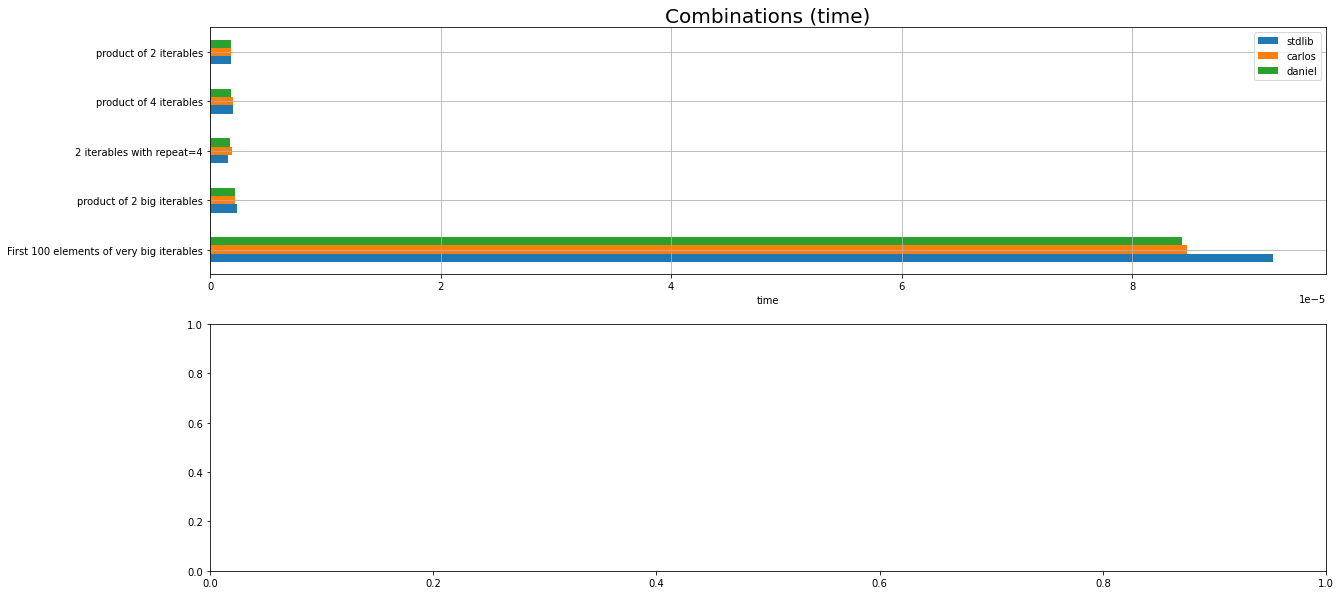

In [46]:
plot(times, memory, modules, "combinations")

# Permutations

In [29]:
def benchmark1(permutations):
    """3 elements, length 2"""
    def f():
        _ = list(permutations("abc", 2))
    return f

def benchmark2(permutations):
    """100 elements, length 3"""
    def f():
        _ = list(permutations(range(100), 3))
    return f

def benchmark3(permutations):
    """first of 10000 elements, length 5"""
    def f():
        _ = next(permutations(range(10000), 5))
    return f

In [33]:
runs = 100

benchmarks = [
    benchmark1,
    benchmark2,
    benchmark3,
]

modules = [stdlib, carlos, daniel]

In [34]:
times = time_benchmarks(benchmarks, modules, "permutations", runs)

Running benchmark [3 elements, length 2]
-- Running benchmarks for stdlib ....................................................................................................
-- Running benchmarks for carlos ....................................................................................................
-- Running benchmarks for daniel ....................................................................................................
Running benchmark [100 elements, length 3]
-- Running benchmarks for stdlib ....................................................................................................
-- Running benchmarks for carlos ....................................................................................................
-- Running benchmarks for daniel ....................................................................................................
Running benchmark [first of 10000 elements, length 5]
-- Running benchmarks for stdlib .........................

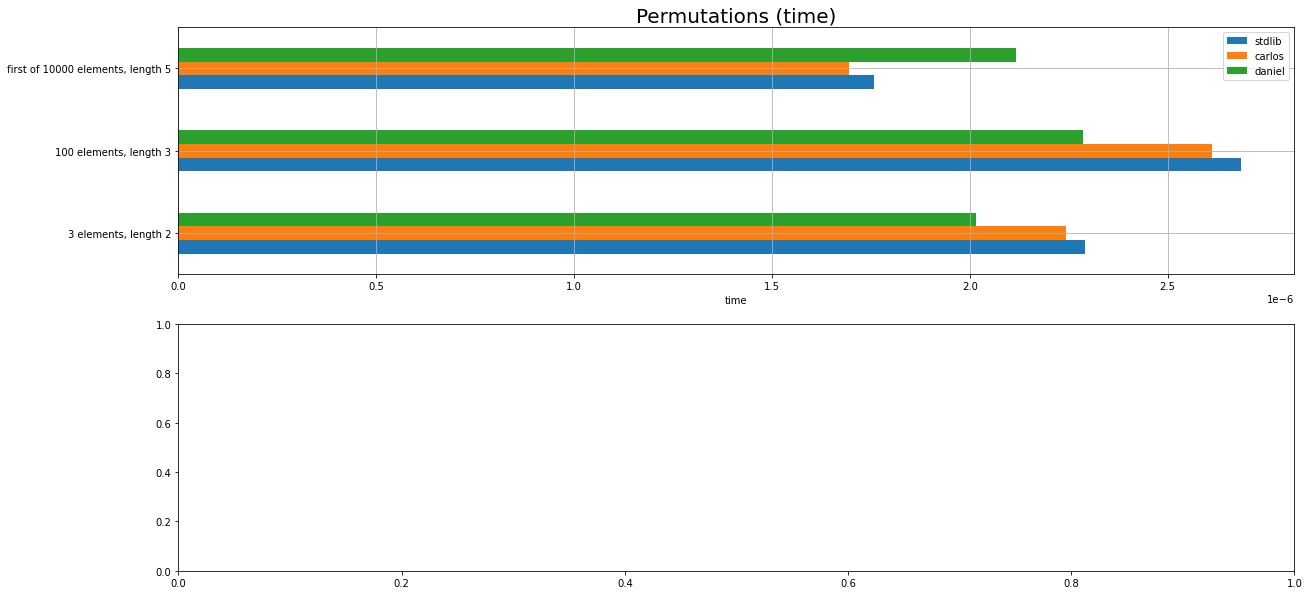

In [35]:
plot(times, memory, modules, "permutations")

# Product

In [40]:
def benchmark1(product):
    """product of 2 iterables"""
    def f():
        _ = list(product([1, 2], "ab"))
    return f

def benchmark2(product):
    """product of 4 iterables"""
    def f():
        _ = list(product([1, 2], ["a", "b"], [True, False], [None, None, None]))
    return f

def benchmark3(product):
    """2 iterables with repeat=4"""
    def f():
        _ = list(product("ab", "cd", repeat=4))
    return f

def benchmark4(product):
    """product of 2 big iterables"""
    def f():
        _ = list(product(range(10000), range(1000)))
    return f

def benchmark5(product):
    """First 100 elements of very big iterables"""
    def f():
        for _ in range(100):
            next(product(range(1000000000), range(1000000000)))
    return f


In [41]:
runs = 100

benchmarks = [
    benchmark1,
    benchmark2,
    benchmark3,
    benchmark4,
    benchmark5,
]

modules = [stdlib, carlos, daniel]

In [42]:
times = time_benchmarks(benchmarks, modules, "product", runs)

Running benchmark [product of 2 iterables]
-- Running benchmarks for stdlib ....................................................................................................
-- Running benchmarks for carlos ....................................................................................................
-- Running benchmarks for daniel ....................................................................................................
Running benchmark [product of 4 iterables]
-- Running benchmarks for stdlib ....................................................................................................
-- Running benchmarks for carlos ....................................................................................................
-- Running benchmarks for daniel ....................................................................................................
Running benchmark [2 iterables with repeat=4]
-- Running benchmarks for stdlib ...............................

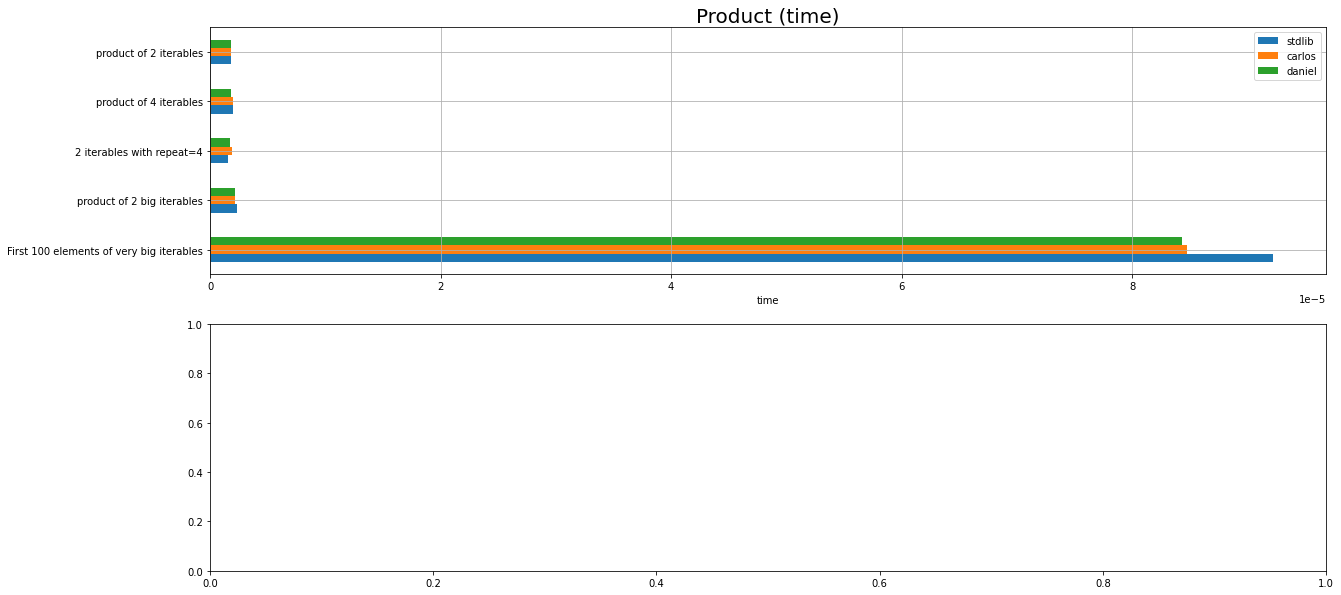

In [48]:
plot(times, memory, modules, "product")